# Assignment on SQL and Machine Learning Application of Database
## Submitted by:

<b><font size="24">
<ul>
    <li> March Archie Gamayan </li>
    <li> Allan Carlo Ramos </li>
    <li> Martin Tinio </li>
</ul>
    </b></font>

In [1]:
!pip3 install mysql-connector-python
!pip3 install python-dotenv

import pandas as pd, os

In [2]:
# Load db-related packages
#%load_ext dotenv
#%dotenv db.env

#import pandas.io.sql as psql
import mysql.connector as mysql
from dotenv import load_dotenv
from dotenv import dotenv_values
from mysql.connector import Error

def openConnection(config):
    '''
    Opens MySQL Connection
    Input config variable from load_dotenv
    Output connection
    '''
    
    connect_iteration = 1
    while (connect_iteration <=3):
        connection = mysql.connect(user = config['DB_USERNAME'],password = config['DB_PASSWORD'],
                           database = config['DB_DATABASE'],host = config['DB_HOST'])
        if (connection.is_connected()):
           return connection
        connection_iteration += 1    
    return(None)

def load_database():
    load_dotenv()
    config = dotenv_values("dotenv.env")

    connection = openConnection(config)

    if(not None==connection):
        print("Connection is opened")
        return connection
    else:
        print("Connection is not opened")
        return null
        

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

## Recency

In [4]:
connection = load_database()
sql = """
SELECT c.name AS customer_name, DATEDIFF('2005-06-01',MAX(o.order_date)) AS days_since_last_order
FROM customers c
    LEFT JOIN orders o ON c.customer_no = o.customer_no
    INNER JOIN (
        SELECT total_completed_orders_2003_table.cust_name AS customer_name,
                 total_completed_orders_2003_table.order_no_count as order_no_count_2003,
                 total_completed_orders_2004_table.order_no_count as order_no_count_2024,
                 total_completed_orders_2005_table.order_no_count as order_no_count_2025
          FROM (SELECT customers.customer_no  AS cust_no,
                       customers.name            cust_name,
                       COUNT(orders.order_no) AS order_no_count
                FROM customers
                         JOIN orders
                              ON customers.customer_no = orders.customer_no
                WHERE orders.order_date >= '2003-01-01'
                  AND orders.order_date <= '2003-12-31'
                  AND orders.status = "Shipped"
                GROUP BY customers.customer_no
                ORDER BY customers.customer_no ASC) total_completed_orders_2003_table
                   left join
               (SELECT customers.customer_no     cust_no,
                       customers.name            cust_name,
                       COUNT(orders.order_no) AS order_no_count
                FROM customers
                         JOIN orders
                              ON customers.customer_no = orders.customer_no
                WHERE orders.order_date >= '2004-01-01'
                  AND orders.order_date <= '2004-12-31'
                  AND orders.status = "Shipped"
                GROUP BY customers.customer_no
                ORDER BY customers.customer_no ASC) total_completed_orders_2004_table
               ON total_completed_orders_2003_table.cust_no = total_completed_orders_2004_table.cust_no
                   LEFT JOIN
               (SELECT customers.customer_no     cust_no,
                       customers.name            cust_name,
                       COUNT(orders.order_no) AS order_no_count
                FROM customers
                         JOIN orders
                              ON customers.customer_no = orders.customer_no
                WHERE orders.order_date >= '2005-01-01'
                  AND orders.order_date <= '2005-12-31'
                  AND orders.status = "Shipped"
                GROUP BY customers.customer_no
                ORDER BY customers.customer_no ASC) total_completed_orders_2005_table
               ON total_completed_orders_2003_table.cust_no = total_completed_orders_2005_table.cust_no
          WHERE NOT (total_completed_orders_2004_table.order_no_count IS NULL
              AND total_completed_orders_2005_table.order_no_count IS NULL)
          UNION
          SELECT total_completed_orders_2004_table.cust_name,
                 total_completed_orders_2003_table.order_no_count,
                 total_completed_orders_2004_table.order_no_count,
                 total_completed_orders_2005_table.order_no_count
          FROM (SELECT customers.customer_no  AS cust_no,
                       customers.name            cust_name,
                       COUNT(orders.order_no) AS order_no_count
                FROM customers
                         JOIN orders
                              ON customers.customer_no = orders.customer_no
                WHERE orders.order_date >= '2003-01-01'
                  AND orders.order_date <= '2003-12-31'
                  AND orders.status = "Shipped"
                GROUP BY customers.customer_no
                ORDER BY customers.customer_no ASC) total_completed_orders_2003_table
                   RIGHT JOIN
               (SELECT customers.customer_no     cust_no,
                       customers.name            cust_name,
                       COUNT(orders.order_no) AS order_no_count
                FROM customers
                         JOIN orders
                              ON customers.customer_no = orders.customer_no
                WHERE orders.order_date >= '2004-01-01'
                  AND orders.order_date <= '2004-12-31'
                  AND orders.status = "Shipped"
                GROUP BY customers.customer_no
                ORDER BY customers.customer_no ASC) total_completed_orders_2004_table
               ON total_completed_orders_2003_table.cust_no = total_completed_orders_2004_table.cust_no
                   LEFT JOIN
               (SELECT customers.customer_no     cust_no,
                       customers.name            cust_name,
                       COUNT(orders.order_no) AS order_no_count
                FROM customers
                         JOIN orders
                              ON customers.customer_no = orders.customer_no
                WHERE orders.order_date >= '2005-01-01'
                  AND orders.order_date <= '2005-12-31'
                  AND orders.status = "Shipped"
                GROUP BY customers.customer_no
                ORDER BY customers.customer_no ASC) total_completed_orders_2005_table
               ON total_completed_orders_2004_table.cust_no = total_completed_orders_2005_table.cust_no
          WHERE total_completed_orders_2003_table.order_no_count IS NULL
            AND NOT total_completed_orders_2005_table.order_no_count IS NULL
        ) table_of_returning_customers ON table_of_returning_customers.customer_name = c.name
WHERE o.status = 'Shipped'
GROUP BY c.name
ORDER BY days_since_last_order DESC;
"""

#df_recency = psql.read_sql(sql, connection).fillna(0)
df_recency = pd.read_sql(sql, connection).fillna(0)

df_recency

Connection is opened


/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,customer_name,days_since_last_order
0,"Men 'R' US Retailers, Ltd.",509
1,"Double Decker Gift Stores, Ltd",496
2,West Coast Collectables Co.,489
3,Frau da Collezione,478
4,Signal Collectibles Ltd.,477
...,...,...
74,Euro+ Shopping Channel,29
75,Gift Depot Inc.,27
76,L'ordine Souveniers,22
77,"Extreme Desk Decorations, Ltd",16


<AxesSubplot:>

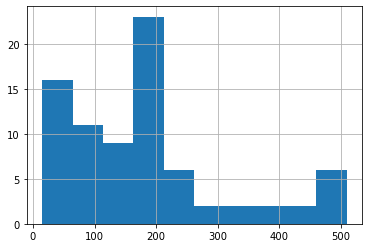

In [5]:
df_recency.days_since_last_order.hist()

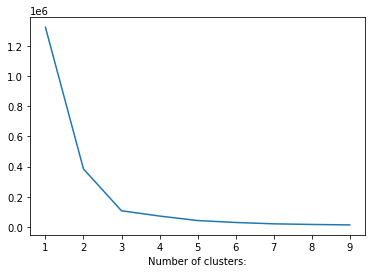

In [6]:
sse={}
df = df_recency[['days_since_last_order']].copy(deep=True)

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df)
    df["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters:")
plt.show()

To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia start decreasing in a linear fashion. Thus for the given data, we conclude that the optimal number of clusters for the data is 3.

In [7]:
kmeans = KMeans(n_clusters=3,random_state=123)
kmeans.fit(df_recency[['days_since_last_order']])
df_recency['r_cluster'] = kmeans.predict(df_recency[['days_since_last_order']])

In [8]:
df_recency

,customer_name,days_since_last_order,r_cluster
0,"Men 'R' US Retailers, Ltd.",509,1
1,"Double Decker Gift Stores, Ltd",496,1
2,West Coast Collectables Co.,489,1
3,Frau da Collezione,478,1
4,Signal Collectibles Ltd.,477,1
...,...,...,...
74,Euro+ Shopping Channel,29,0
75,Gift Depot Inc.,27,0
76,L'ordine Souveniers,22,0
77,"Extreme Desk Decorations, Ltd",16,0


In [9]:
df_recency.groupby(by='r_cluster').describe()

days_since_last_order                                               \
                          count        mean        std    min     25%    50%   
r_cluster                                                                      
0                          30.0   65.933333  32.606254   15.0   39.25   62.0   
1                          12.0  441.333333  56.978997  334.0  399.00  461.0   
2                          37.0  195.432432  33.346281  132.0  180.00  196.0   

                          
              75%    max  
r_cluster                 
0           90.00  121.0  
1          480.75  509.0  
2          209.00  284.0

## Frequency

In [10]:
connection = load_database()
sql = """
SELECT c.name AS customer_name, COUNT(DISTINCT order_no) AS total_order_count
FROM customers c
    LEFT JOIN orders o ON c.customer_no = o.customer_no
    INNER JOIN (
        SELECT total_completed_orders_2003_table.cust_name AS customer_name,
                 total_completed_orders_2003_table.order_no_count as order_no_count_2003,
                 total_completed_orders_2004_table.order_no_count as order_no_count_2024,
                 total_completed_orders_2005_table.order_no_count as order_no_count_2025
          FROM (SELECT customers.customer_no  AS cust_no,
                       customers.name            cust_name,
                       COUNT(orders.order_no) AS order_no_count
                FROM customers
                         JOIN orders
                              ON customers.customer_no = orders.customer_no
                WHERE orders.order_date >= '2003-01-01'
                  AND orders.order_date <= '2003-12-31'
                  AND orders.status = "Shipped"
                GROUP BY customers.customer_no
                ORDER BY customers.customer_no ASC) total_completed_orders_2003_table
                   left join
               (SELECT customers.customer_no     cust_no,
                       customers.name            cust_name,
                       COUNT(orders.order_no) AS order_no_count
                FROM customers
                         JOIN orders
                              ON customers.customer_no = orders.customer_no
                WHERE orders.order_date >= '2004-01-01'
                  AND orders.order_date <= '2004-12-31'
                  AND orders.status = "Shipped"
                GROUP BY customers.customer_no
                ORDER BY customers.customer_no ASC) total_completed_orders_2004_table
               ON total_completed_orders_2003_table.cust_no = total_completed_orders_2004_table.cust_no
                   LEFT JOIN
               (SELECT customers.customer_no     cust_no,
                       customers.name            cust_name,
                       COUNT(orders.order_no) AS order_no_count
                FROM customers
                         JOIN orders
                              ON customers.customer_no = orders.customer_no
                WHERE orders.order_date >= '2005-01-01'
                  AND orders.order_date <= '2005-12-31'
                  AND orders.status = "Shipped"
                GROUP BY customers.customer_no
                ORDER BY customers.customer_no ASC) total_completed_orders_2005_table
               ON total_completed_orders_2003_table.cust_no = total_completed_orders_2005_table.cust_no
          WHERE NOT (total_completed_orders_2004_table.order_no_count IS NULL
              AND total_completed_orders_2005_table.order_no_count IS NULL)
          UNION
          SELECT total_completed_orders_2004_table.cust_name,
                 total_completed_orders_2003_table.order_no_count,
                 total_completed_orders_2004_table.order_no_count,
                 total_completed_orders_2005_table.order_no_count
          FROM (SELECT customers.customer_no  AS cust_no,
                       customers.name            cust_name,
                       COUNT(orders.order_no) AS order_no_count
                FROM customers
                         JOIN orders
                              ON customers.customer_no = orders.customer_no
                WHERE orders.order_date >= '2003-01-01'
                  AND orders.order_date <= '2003-12-31'
                  AND orders.status = "Shipped"
                GROUP BY customers.customer_no
                ORDER BY customers.customer_no ASC) total_completed_orders_2003_table
                   RIGHT JOIN
               (SELECT customers.customer_no     cust_no,
                       customers.name            cust_name,
                       COUNT(orders.order_no) AS order_no_count
                FROM customers
                         JOIN orders
                              ON customers.customer_no = orders.customer_no
                WHERE orders.order_date >= '2004-01-01'
                  AND orders.order_date <= '2004-12-31'
                  AND orders.status = "Shipped"
                GROUP BY customers.customer_no
                ORDER BY customers.customer_no ASC) total_completed_orders_2004_table
               ON total_completed_orders_2003_table.cust_no = total_completed_orders_2004_table.cust_no
                   LEFT JOIN
               (SELECT customers.customer_no     cust_no,
                       customers.name            cust_name,
                       COUNT(orders.order_no) AS order_no_count
                FROM customers
                         JOIN orders
                              ON customers.customer_no = orders.customer_no
                WHERE orders.order_date >= '2005-01-01'
                  AND orders.order_date <= '2005-12-31'
                  AND orders.status = "Shipped"
                GROUP BY customers.customer_no
                ORDER BY customers.customer_no ASC) total_completed_orders_2005_table
               ON total_completed_orders_2004_table.cust_no = total_completed_orders_2005_table.cust_no
          WHERE total_completed_orders_2003_table.order_no_count IS NULL
            AND NOT total_completed_orders_2005_table.order_no_count IS NULL
        ) table_of_returning_customers ON table_of_returning_customers.customer_name = c.name
WHERE o.status = 'Shipped'
GROUP BY c.name
ORDER BY total_order_count DESC

;
"""

df_frequency = pd.read_sql(sql, connection).fillna(0)
df_frequency

Connection is opened


/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,customer_name,total_order_count
0,Euro+ Shopping Channel,22
1,Mini Gifts Distributors Ltd.,16
2,"Dragon Souveniers, Ltd.",5
3,"Down Under Souveniers, Inc",5
4,"Australian Collectors, Co.",5
...,...,...
74,Mini Classics,2
75,Daedalus Designs Imports,2
76,Diecast Collectables,2
77,"Double Decker Gift Stores, Ltd",2


<AxesSubplot:>

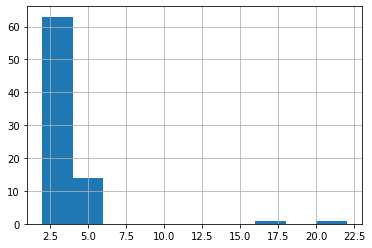

In [11]:
df_frequency.total_order_count.hist()

/var/folders/4f/zws7d0td6vjfvvt5z1_q472m0000gn/T/ipykernel_28195/796458819.py:5: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df)
/var/folders/4f/zws7d0td6vjfvvt5z1_q472m0000gn/T/ipykernel_28195/796458819.py:5: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df)
/var/folders/4f/zws7d0td6vjfvvt5z1_q472m0000gn/T/ipykernel_28195/796458819.py:5: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df)


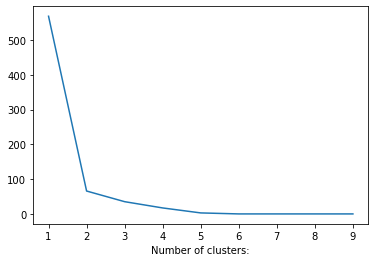

In [12]:
sse={}
df = df_frequency[['total_order_count']].copy(deep=True)

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df)
    df["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters:")
plt.show()

In [13]:
kmeans = KMeans(n_clusters=3,random_state=123)
kmeans.fit(df_frequency[['total_order_count']])
df_frequency['f_cluster'] = kmeans.predict(df_frequency[['total_order_count']])

In [14]:
df_frequency

,customer_name,total_order_count,f_cluster
0,Euro+ Shopping Channel,22,1
1,Mini Gifts Distributors Ltd.,16,1
2,"Dragon Souveniers, Ltd.",5,2
3,"Down Under Souveniers, Inc",5,2
4,"Australian Collectors, Co.",5,2
...,...,...,...
74,Mini Classics,2,0
75,Daedalus Designs Imports,2,0
76,Diecast Collectables,2,0
77,"Double Decker Gift Stores, Ltd",2,0


In [15]:
df_frequency.groupby(by='f_cluster').describe()

total_order_count                                                \
                      count       mean       std   min   25%   50%    75%   
f_cluster                                                                   
0                      63.0   2.650794  0.480548   2.0   2.0   3.0   3.00   
1                       2.0  19.000000  4.242641  16.0  17.5  19.0  20.50   
2                      14.0   4.285714  0.468807   4.0   4.0   4.0   4.75   

                 
            max  
f_cluster        
0           3.0  
1          22.0  
2           5.0

## Monetary

In [16]:
connection = load_database()
sql = """
SELECT c.name AS customer_name, SUM(od.price_each * od.quantity_ordered) AS total_amount_sold
FROM customers c
    LEFT JOIN orders o ON c.customer_no = o.customer_no
    LEFT JOIN order_details od ON od.order_no = o.order_no
    INNER JOIN (
        SELECT total_completed_orders_2003_table.cust_name AS customer_name,
                 total_completed_orders_2003_table.order_no_count as order_no_count_2003,
                 total_completed_orders_2004_table.order_no_count as order_no_count_2024,
                 total_completed_orders_2005_table.order_no_count as order_no_count_2025
          FROM (SELECT customers.customer_no  AS cust_no,
                       customers.name            cust_name,
                       COUNT(orders.order_no) AS order_no_count
                FROM customers
                         JOIN orders
                              ON customers.customer_no = orders.customer_no
                WHERE orders.order_date >= '2003-01-01'
                  AND orders.order_date <= '2003-12-31'
                  AND orders.status = "Shipped"
                GROUP BY customers.customer_no
                ORDER BY customers.customer_no ASC) total_completed_orders_2003_table
                   left join
               (SELECT customers.customer_no     cust_no,
                       customers.name            cust_name,
                       COUNT(orders.order_no) AS order_no_count
                FROM customers
                         JOIN orders
                              ON customers.customer_no = orders.customer_no
                WHERE orders.order_date >= '2004-01-01'
                  AND orders.order_date <= '2004-12-31'
                  AND orders.status = "Shipped"
                GROUP BY customers.customer_no
                ORDER BY customers.customer_no ASC) total_completed_orders_2004_table
               ON total_completed_orders_2003_table.cust_no = total_completed_orders_2004_table.cust_no
                   LEFT JOIN
               (SELECT customers.customer_no     cust_no,
                       customers.name            cust_name,
                       COUNT(orders.order_no) AS order_no_count
                FROM customers
                         JOIN orders
                              ON customers.customer_no = orders.customer_no
                WHERE orders.order_date >= '2005-01-01'
                  AND orders.order_date <= '2005-12-31'
                  AND orders.status = "Shipped"
                GROUP BY customers.customer_no
                ORDER BY customers.customer_no ASC) total_completed_orders_2005_table
               ON total_completed_orders_2003_table.cust_no = total_completed_orders_2005_table.cust_no
          WHERE NOT (total_completed_orders_2004_table.order_no_count IS NULL
              AND total_completed_orders_2005_table.order_no_count IS NULL)
          UNION
          SELECT total_completed_orders_2004_table.cust_name,
                 total_completed_orders_2003_table.order_no_count,
                 total_completed_orders_2004_table.order_no_count,
                 total_completed_orders_2005_table.order_no_count
          FROM (SELECT customers.customer_no  AS cust_no,
                       customers.name            cust_name,
                       COUNT(orders.order_no) AS order_no_count
                FROM customers
                         JOIN orders
                              ON customers.customer_no = orders.customer_no
                WHERE orders.order_date >= '2003-01-01'
                  AND orders.order_date <= '2003-12-31'
                  AND orders.status = "Shipped"
                GROUP BY customers.customer_no
                ORDER BY customers.customer_no ASC) total_completed_orders_2003_table
                   RIGHT JOIN
               (SELECT customers.customer_no     cust_no,
                       customers.name            cust_name,
                       COUNT(orders.order_no) AS order_no_count
                FROM customers
                         JOIN orders
                              ON customers.customer_no = orders.customer_no
                WHERE orders.order_date >= '2004-01-01'
                  AND orders.order_date <= '2004-12-31'
                  AND orders.status = "Shipped"
                GROUP BY customers.customer_no
                ORDER BY customers.customer_no ASC) total_completed_orders_2004_table
               ON total_completed_orders_2003_table.cust_no = total_completed_orders_2004_table.cust_no
                   LEFT JOIN
               (SELECT customers.customer_no     cust_no,
                       customers.name            cust_name,
                       COUNT(orders.order_no) AS order_no_count
                FROM customers
                         JOIN orders
                              ON customers.customer_no = orders.customer_no
                WHERE orders.order_date >= '2005-01-01'
                  AND orders.order_date <= '2005-12-31'
                  AND orders.status = "Shipped"
                GROUP BY customers.customer_no
                ORDER BY customers.customer_no ASC) total_completed_orders_2005_table
               ON total_completed_orders_2004_table.cust_no = total_completed_orders_2005_table.cust_no
          WHERE total_completed_orders_2003_table.order_no_count IS NULL
            AND NOT total_completed_orders_2005_table.order_no_count IS NULL
        ) table_of_returning_customers ON table_of_returning_customers.customer_name = c.name
WHERE o.status = 'Shipped'
GROUP BY c.name
ORDER BY total_amount_sold DESC
;
"""

df_monetary = pd.read_sql(sql, connection)
df_monetary

Connection is opened


/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,customer_name,total_amount_sold
0,Euro+ Shopping Channel,668770.46
1,Mini Gifts Distributors Ltd.,584188.24
2,"Australian Collectors, Co.",180585.07
3,Muscle Machine Inc,177913.95
4,"Dragon Souveniers, Ltd.",156251.03
...,...,...
74,Frau da Collezione,25358.32
75,Mini Auto Werke,23938.09
76,Atelier graphique,22314.36
77,Auto-Moto Classics Inc.,21554.26


<AxesSubplot:>

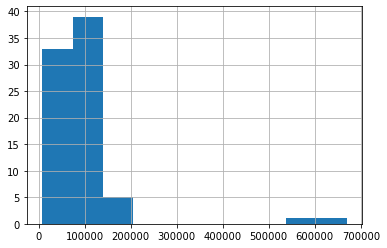

In [17]:
df_monetary.total_amount_sold.hist()

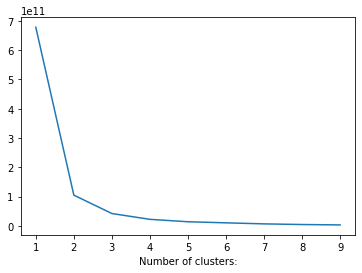

In [18]:
sse={}
df = df_monetary[['total_amount_sold']].copy(deep=True)

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df)
    df["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters:")
plt.show()

In [19]:
kmeans = KMeans(n_clusters=3,random_state=123)
kmeans.fit(df_monetary[['total_amount_sold']])
df_monetary['m_cluster'] = kmeans.predict(df_monetary[['total_amount_sold']])

In [20]:
df_monetary

,customer_name,total_amount_sold,m_cluster
0,Euro+ Shopping Channel,668770.46,1
1,Mini Gifts Distributors Ltd.,584188.24,1
2,"Australian Collectors, Co.",180585.07,2
3,Muscle Machine Inc,177913.95,2
4,"Dragon Souveniers, Ltd.",156251.03,2
...,...,...,...
74,Frau da Collezione,25358.32,0
75,Mini Auto Werke,23938.09,0
76,Atelier graphique,22314.36,0
77,Auto-Moto Classics Inc.,21554.26,0


In [21]:
df_monetary.groupby(by='m_cluster').describe()

total_amount_sold                                          \
                      count           mean           std        min   
m_cluster                                                             
0                      40.0   56411.929500  19402.244349    7918.60   
1                       2.0  626479.350000  59808.661330  584188.24   
2                      37.0  113605.602973  25581.006321   86436.97   

                                                          
                   25%        50%         75%        max  
m_cluster                                                 
0           43731.7025   61474.44   70670.870   80556.73  
1          605333.7950  626479.35  647624.905  668770.46  
2           91655.6100  105548.73  127529.690  180585.07

## Clustering

In [22]:
df_customers = df_recency.merge(df_frequency,how='left', left_on='customer_name', right_on='customer_name').merge(df_monetary,how='left', left_on='customer_name', right_on='customer_name')
df_customers

,customer_name,days_since_last_order,r_cluster,total_order_count,f_cluster,total_amount_sold,m_cluster
0,"Men 'R' US Retailers, Ltd.",509,1,2,0,41506.19,0
1,"Double Decker Gift Stores, Ltd",496,1,2,0,29586.15,0
2,West Coast Collectables Co.,489,1,2,0,43748.72,0
3,Frau da Collezione,478,1,2,0,25358.32,0
4,Signal Collectibles Ltd.,477,1,2,0,42570.37,0
...,...,...,...,...,...,...,...
74,Euro+ Shopping Channel,29,0,22,1,668770.46,1
75,Gift Depot Inc.,27,0,3,0,95424.63,2
76,L'ordine Souveniers,22,0,3,0,125505.57,2
77,"Extreme Desk Decorations, Ltd",16,0,3,0,90332.38,2


In [23]:
df_customers['overall_score'] = df_customers['r_cluster'] + df_customers['f_cluster'] + df_customers['m_cluster']
df_customers.groupby('overall_score')['days_since_last_order','total_order_count','total_amount_sold'].mean().style.format('{:,.2f}'.format)


/var/folders/4f/zws7d0td6vjfvvt5z1_q472m0000gn/T/ipykernel_28195/652207231.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_customers.groupby('overall_score')['days_since_last_order','total_order_count','total_amount_sold'].mean().style.format('{:,.2f}'.format)


,days_since_last_order,total_order_count,total_amount_sold
overall_score,,,
0,71.20,2.50,"55,463.24"
1,448.20,2.00,"47,214.37"
2,145.27,3.90,"112,594.60"
3,407.00,3.00,"108,593.49"
4,148.61,3.48,"109,729.26"
6,180.25,4.25,"141,817.26"


In [24]:
df_customers.groupby('overall_score')['days_since_last_order','total_order_count','total_amount_sold'].median().style.format('{:,.2f}'.format)

/var/folders/4f/zws7d0td6vjfvvt5z1_q472m0000gn/T/ipykernel_28195/1227973130.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_customers.groupby('overall_score')['days_since_last_order','total_order_count','total_amount_sold'].median().style.format('{:,.2f}'.format)


,days_since_last_order,total_order_count,total_amount_sold
overall_score,,,
0,70.50,2.50,"60,825.27"
1,471.50,2.00,"44,334.74"
2,179.50,3.00,"78,079.38"
3,407.00,3.00,"108,593.49"
4,166.00,3.00,"107,639.94"
6,183.00,4.00,"141,229.59"


### Customer Segments (PLEASE UPDATE THIS BASED ON THE OVERALL SCORE)

<ul>
    <li><b>Lost - 1</b> (small ave order, long order duration, low monetary)</li>
    <li><b>Sleepers - 3</b> ( long order duration but with highest average value at mostly average orders)</li>
    <li><b>Needs Attention - 0</b> (shortest order duration, but with potential reordering points and can catch up with the order volume of other clusters)</li>
    <li><b>Loyal Customers - 2,4,6</b> (clusters who regularly orders every 6 months with highest average number of orders which gives the highest monetary contributions</li>
</ul>